In [1]:
!pip3 install scikit-surprise




[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
from surprise import NMF
from surprise.model_selection import cross_validate, KFold

from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import numpy as np
import torch
from torch.optim import SGD
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import pandas as pd


# Run Nonnegative Matrix Factorization

In [3]:

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Get randomly filtered data
def get_filtered_dataset(E=943):
    # Convert the dataset to a pandas DataFrame
    raw_ratings = data.raw_ratings
    df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

    sampled_users = np.random.choice(df['user_id'].unique(), size=E, replace=False)

    # Filter the dataset for the sampled users
    filtered_df = df[df['user_id'].isin(sampled_users)]

    # Convert the filtered DataFrame back to a Surprise Dataset
    reader = Reader(rating_scale=(1, 5))  # Adjust the rating_scale according to your dataset
    filtered_data = Dataset.load_from_df(filtered_df[['user_id', 'item_id', 'rating']], reader)
    
    return filtered_data
 
    
# Function to get embeddings for a filtered sample 
def get_embeddings_random(n_factors, filtered_data):
    # Apply NMF
    algo = NMF(n_factors=n_factors)

    # Cross-validation
    kf = KFold(n_splits=5)
    for trainset, testset in kf.split(filtered_data):
        algo.fit(trainset)
        predictions = algo.test(testset)

    # Access the user embeddings
    user_embeddings = algo.pu
    return user_embeddings

# Function to get embeddings on full dataset
def get_embeddings(n_factors, E=943):
    filtered_data = get_filtered_dataset(E=943)
    return get_embeddings_random(n_factors, filtered_data)

# Compute threshold $\beta_u$

In [4]:

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_beta_threshold_upper(user_embeddings_np, p=2):

    user_embeddings_np = user_embeddings_np
    N = user_embeddings_np.shape[0] # number of users 
    q = 1/(1-1/p) # dual norm 

    normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np, ord=q, axis=1, keepdims=True)
    sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
    beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows, ord=q)))

    return beta_ub

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for q = 2 
def get_beta_threshold_cost_weights(user_embeddings_np, cost_weights, p=2):

    N = user_embeddings_np.shape[0]
    normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np * np.power(cost_weights, -1), ord=2, axis=1, keepdims=True)
    sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
    beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows * np.power(cost_weights, -1), ord=2)))

    return beta_ub





## Compute threshold $\beta_e$ 

In [5]:

# Figure out if there is a point in convex hull of ball with objective > 0
def condition(ball):
    # Number of points and dimensions
    num_points = ball.shape[0]
    num_dims = ball.shape[1]
    
    param = 1.5e-6
    
    # tune tolerance to the number of users
    if num_dims == 30:
        param = 1.5e-6
    if num_dims == 20:
        param = 0.85e-6
    if num_dims == 40:
        param = 1.9e-6

    weights = cp.Variable(num_points)

    weighted_sums = cp.sum(cp.log(cp.matmul(ball.T, weights)))

    constraints = [
        weights >= 0,
        cp.sum(weights) == 1,
        weighted_sums >= param
    ]

    prob = cp.Problem(cp.Maximize(1), constraints)

    prob.solve(abstol=1e-7)
        
    if prob.status == 'optimal':
        print("The problem is feasible.")
        in_convex_hull = True
    else:
        print("The problem is infeasible.")
        in_convex_hull = False 
    
    return in_convex_hull


def binary_search_for_beta(lower_bound, upper_bound, max_point, user_embeddings_np, p, tolerance=0.1):
    
    T = 50
    num_samples = 75
    D = user_embeddings_np.shape[1] # dimension
    N = user_embeddings_np.shape[0] # number of users 
    projected_max_point = max_point @ user_embeddings_np.T 
    
    while upper_bound - lower_bound > tolerance:
        mid = (upper_bound + lower_bound) / 2
        print('\n')
        print(f'beta = {mid}')
        print(f'mid={mid}, lower bound = {lower_bound}, upper bound = {upper_bound}')

        condition_holds = False 
        for t in range(T):
            # Build ball to test in 
            random_points = np.random.multivariate_normal(np.zeros(D), np.eye(D), num_samples)

            random_points = np.abs(random_points) 

            # Scale by the norm
            norms = np.linalg.norm(random_points, axis=1, keepdims=True, ord=p)
        
            random_points = random_points / norms
        
            ball = np.vstack([random_points, max_point])
            
            ball = ball @ user_embeddings_np.T 
  
            inside_ball = ball / projected_max_point # divide out the target 

            # Compute powers 
            powered = np.power(inside_ball, mid)


            condition_holds = condition(powered)

            if condition_holds:
                break 
                
        if condition_holds:
            upper_bound = mid
        else:
            lower_bound = mid 
            
    return (upper_bound + lower_bound) / 2

# Get the single-genre equilibrium direction
def get_maximum(user_embeddings_np, p=2):
    
    N = user_embeddings_np.shape[0] # number of users 
    D = user_embeddings_np.shape[1] # dimension
    point = cp.Variable(D)

    constraints = [
        cp.pnorm(point, p) <= 1,
    ]

    prob = cp.Problem(cp.Maximize(cp.sum(cp.log(cp.matmul(user_embeddings_np, point)))), constraints)

    prob.solve()
    
    # Check if the problem is feasible
    return np.array(point.value)
    

def get_beta_threshold(user_embeddings_np, p=2):
    
    N = user_embeddings_np.shape[0] # number of users 
    D = user_embeddings_np.shape[1] # dimension

    print(N, D)

    max_point = get_maximum(user_embeddings_np, p=p)
    
    print(f'upper bound: {get_beta_threshold_upper(user_embeddings_np, p)}')
    beta_ub = get_beta_threshold_upper(user_embeddings_np, p)
    beta_lb = 1

    eps=0.05
    
    print("start binary search")
    
    beta_max = binary_search_for_beta(beta_lb, beta_ub, max_point, user_embeddings_np, p, tolerance=eps)

    return beta_max


# Compute single-genre equilibrium $p^*$ 

In [13]:

# Compute the single-genre equilibrium p^* for cost functions c_{q, \alpha, \beta} for q = 2 
def get_first_objective(U, dim, p=2, learning_rate=1.0, cost_weights=None):
    x = cp.Variable(dim)
    objective = cp.Maximize(cp.sum(cp.log(U @ x)))
    constraints = [cp.norm(cp.multiply(x, cost_weights), p) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(x.value)
    return x.value

def get_first_objective_no_cost(U, dim, p=2, learning_rate=1.0):
    x = cp.Variable(dim)
    objective = cp.Maximize(cp.sum(cp.log(U @ x)))
    constraints = [cp.pnorm(x, p) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(x.value)
    return x.value
    
# Project onto q-norm ball 
def project_onto_norm_ball(x, q, cost_weights):
    dim = len(x)
    y = cp.Variable(dim)
    objective = cp.Minimize(cp.norm2(x-y))
    constraints = [cp.norm(cp.multiply(y, cost_weights), q) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return y.value

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_first_objective_old(U, D, p=2, learning_rate=1.0, cost_weights=None):
    if cost_weights==None:
        cost_weights = torch.ones(D)

    x = torch.clamp(torch.randn(D), min=1.0)
    x.requires_grad = True
    optimizer = SGD([x], lr=learning_rate)
    num_iterations = 100

    for _ in tqdm(range(num_iterations)):
        optimizer.zero_grad()

        loss = -1 * torch.sum(torch.log(torch.matmul(U, x)))

        loss.backward()  # computes the gradient

        optimizer.step()

        with torch.no_grad():
            x.clamp_(min=0)
            x_numpy = x.detach().numpy()
            projected_x = project_onto_norm_ball(x_numpy, p, cost_weights)
            x.copy_(torch.from_numpy(projected_x))
  
    print(x)
    print("Objective:", -1 * loss.item())

    return x.detach().numpy(), -1 * loss.item()



# Generate data for plots 

In [47]:

# Compute \beta_u data across different dimensions and values of q

def get_betas_upper_bound_all(p_values, dim_values):
    betas = []
    for j in range(len(dim_values)):
        betas_p = []
        dim = dim_values[j]
        user_embeddings_np = get_embeddings(dim)
      
        for i in range(len(p_values)):
            q = p_values[i]
            beta_ub = get_beta_threshold_upper(user_embeddings_np, p=q)
            betas_p.append(beta_ub)

            print(f'beta value: {beta_ub} at D = {dim} at p = {q}')
            print('\n\n')

        betas.append(betas_p)
    return betas



In [6]:


# Compute \beta_e data across different dimensions and values of N

def get_betas_all(N_values, dim_values):
    betas = []
    for i in range(len(N_values)):
        N = N_values[i]
        filtered_data = get_filtered_dataset(E=N) # sample users
        betas_p = []
        for j in range(len(dim_values)):
            dim = dim_values[j]
            user_embeddings_np = get_embeddings_random(dim, filtered_data)
            beta = get_beta_threshold(user_embeddings_np, p=2)
            betas_p.append(beta)

            print(f'beta value: {beta} at D = {dim} at N = {N}')
            print('\n\n')

        betas.append(betas_p)
    return betas

In [10]:
# Compute single-genre equilibria data 

def get_data_costs_weighted(dim, costs_weights_all):
    user_embeddings = get_embeddings(dim)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = 4
    p_vals = []
    for i in range(S):
        cost_weights = costs_weights_all[i]
        p = get_first_objective(U, dim, p=2, cost_weights=cost_weights)
        p = p / np.linalg.norm(p)
        print(f'alpha = {cost_weights}, p = {p / np.sum(p)}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



def get_data_costs_qvals(dim, q_vals):
    user_embeddings = get_embeddings(dim)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = len(q_vals)
    p_vals = []
    for i in range(S):
        q = q_vals[i]
        p = get_first_objective_no_cost(U, dim, p=q)
        p = p / np.linalg.norm(p)
        print(f'q = {q}, p = {p}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



In [8]:

# Generate S weight vectors \alpha 
def generate_cost_weights(dim, S):
    cost_weights_all = []
    if dim == 3:
        for i in range(S):
            cost_weights = torch.rand(dim)
            cost_weights = cost_weights / torch.sum(cost_weights)
            cost_weights_all.append(cost_weights)
    if dim == 2:
        for i in range(S):
            shift = 1/(2 * S)
            cost_weights = torch.zeros(dim)
            cost_weights[0] = shift + (i / (S+1))
            cost_weights[1] = 1 - cost_weights[0]
            cost_weights_all.append(cost_weights)
    return cost_weights_all

In [14]:

cost_weights_all_2d = generate_cost_weights(2, 4)
p_vals_weighted2, user_embeddings_weighted2, mean_embedding_weighted2  = get_data_costs_weighted(2, cost_weights_all_2d)

# Save data to a file
np.savetxt('./Data/p_vals_weighted2.txt', p_vals_weighted2)
np.savetxt('./Data/user_embeddings_weighted2.txt', user_embeddings_weighted2)
np.savetxt('./Data/mean_embedding_weighted2.txt', mean_embedding_weighted2)
np.savetxt('./Data/cost_weights_all_2d.txt', cost_weights_all_2d)



[7.89209745 0.18707194]
alpha = tensor([0.1250, 0.8750]), p = [0.97684515 0.02315485]
[2.72101336 0.69164985]
alpha = tensor([0.3250, 0.6750]), p = [0.79732842 0.20267158]
[1.26834222 1.57065085]
alpha = tensor([0.5250, 0.4750]), p = [0.44675777 0.55324223]
[0.51783119 3.37037017]
alpha = tensor([0.7250, 0.2750]), p = [0.13318014 0.86681986]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [126]:

# Generate data
cost_weights_all_3d = generate_cost_weights(3, 4)
p_vals_weighted3, user_embeddings_weighted3, mean_embedding_weighted3 = get_data_costs_weighted(3, cost_weights_all_3d)

# Save data to file
np.savetxt('./Data/cost_weights_all_3d.txt', cost_weights_all_3d)
np.savetxt('./Data/p_vals_weighted3.txt', p_vals_weighted3)
np.savetxt('./Data/user_embeddings_weighted3.txt', user_embeddings_weighted3)
np.savetxt('./Data/mean_embedding_weighted3.txt', mean_embedding_weighted3)

[4.28165318 1.14065083 0.96785277]
alpha = tensor([0.1860, 0.3872, 0.4268]), p = [0.67003883 0.17850123 0.15145994]
[0.93566028 1.54612087 3.19011387]
alpha = tensor([0.4235, 0.3409, 0.2357]), p = [0.16496432 0.27259335 0.56244233]
[0.84234001 6.80416274 0.59491436]
alpha = tensor([0.3834, 0.1325, 0.4841]), p = [0.10220815 0.82560592 0.07218593]
[3.20576329e-02 1.13706918e+02 6.14262994e-02]
alpha = tensor([0.5609, 0.0088, 0.4304]), p = [2.81700524e-04 9.99178527e-01 5.39772253e-04]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [136]:

q_vals = [1.1, 1.5, 2, 3, 4]

# Generate data
p_vals_qvals2, user_embeddings_qvals2, mean_embedding_qvals2 = get_data_costs_qvals(2, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals2.txt', p_vals_qvals2)
np.savetxt('./Data/user_embeddings_qvals2.txt', user_embeddings_qvals2)
np.savetxt('./Data/mean_embedding_qvals2.txt', mean_embedding_qvals2)
np.savetxt('./Data/q_vals.txt', q_vals)

[0.6139459  0.44982489]
q = 1.1, p = [0.80665687 0.59102004]
[0.65574525 0.60363679]
q = 1.5, p = [0.73573466 0.67726989]
[0.72221441 0.69166925]
q = 2, p = [0.72221441 0.69166925]
[0.80236937 0.78483809]
q = 3, p = [0.71487343 0.69925388]
[0.84706652 0.83458743]
q = 4, p = [0.71233442 0.70184021]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [152]:
q_vals = [1.1, 1.5, 2, 3, 4]
# Generate data
p_vals_qvals3, user_embeddings_qvals3, mean_embedding_qvals3 = get_data_costs_qvals(3, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals3.txt', p_vals_qvals3)
np.savetxt('./Data/user_embeddings_qvals3.txt', user_embeddings_qvals3)
np.savetxt('./Data/mean_embedding_qvals3.txt', mean_embedding_qvals3)
np.savetxt('./Data/q_vals.txt', q_vals)

[0.39955754 0.4164439  0.28764965]
q = 1.1, p = [0.61962615 0.6458132  0.44608155]
[0.49169981 0.49779051 0.45211635]
q = 1.5, p = [0.59024004 0.59755135 0.54272376]
[0.58423592 0.58806025 0.55933312]
q = 2, p = [0.58423592 0.58806025 0.55933311]
[0.69759581 0.69994631 0.68227684]
q = 3, p = [0.58091318 0.58287053 0.56815652]
[0.76295599 0.76468474 0.75166977]
q = 4, p = [0.57975445 0.5810681  0.57117829]


In [12]:

N_vals = [20, 30, 40]
dim_values = [4, 5, 6, 8]

# Generate data
betas = get_betas_all(N_vals, dim_values)

print(betas)

# Save data to files
np.savetxt('./Data/betas_actual.txt', betas)
np.savetxt('./Data/N_vals_actual.txt', N_vals)
np.savetxt('./Data/dim_values_actual.txt', dim_values)

20 4
upper bound: 26.55218784418515
start binary search


beta = 13.776093922092574
mid=13.776093922092574, lower bound = 1, upper bound = 26.55218784418515
The problem is feasible.


beta = 7.388046961046287
mid=7.388046961046287, lower bound = 1, upper bound = 13.776093922092574
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 4.1940234805231436
mid=4.1940234805231436, lower bound = 1, upper bound = 7.388046961046287
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.


beta = 3.193909568794534
mid=3.193909568794534, lower bound = 2.462606379196356, upper bound = 3.925212758392712
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeas

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 2.6518918913241243
mid=2.6518918913241243, lower bound = 2.3215135130592994, upper bound = 2.982270269588949
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infea

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.


beta = 2.669913937873317
mid=2.669913937873317, lower bound = 2.5181035798848335, upper bound = 2.8217242958618005
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infe

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 2.478659247579275
mid=2.478659247579275, lower bound = 1, upper bound = 3.957318495158549
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem 

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.


beta = 3.4413325211370305
mid=3.4413325211370305, lower bound = 2.6275550140913535, upper bound = 4.255110028182707
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 3.034443767614192
mid=3.034443767614192, lower bound = 2.6275550140913535, upper bound = 3.4413325211370305
The problem is infeasible.
The problem is feasible.


beta = 2.8309993908527726
mid=2.830999

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


b

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
beta value: 9.162964905959537 at D = 4 at N = 40



40 5
upper bound: 29.949142678494624
start binary search


beta = 15.474571339247312
mid=15.474571339247312, lower bound = 1, upper bound = 29.949142678494624
The problem is feasible.


beta = 8.237285669623656
mid=8.237285669623656, lower bound = 1, upper bound = 15.474571339247312
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is i

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 1.834999738366077
mid=1.834999738366077, lower bound = 1, upper bound = 2.669999476732154
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem 

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

In [187]:


q_vals =  [1.5, 1.6, 1.8, 2.0]
dim_values = [5, 10, 20, 40]

betas = get_betas_upper_bound_all(q_vals, dim_values)

print(betas)

# Save data to files
np.savetxt('./Data/betas_small.txt', betas)
np.savetxt('./Data/q_vals_small.txt', q_vals)
np.savetxt('./Data/dim_values_small.txt', dim_values)
print(dim_values)
print(q_vals)

beta value: 61.674252544691264 at D = 5 at p = 1.5



beta value: 70.09728488125663 at D = 5 at p = 1.6



beta value: 86.83793661650714 at D = 5 at p = 1.8



beta value: 103.48361086666183 at D = 5 at p = 2.0



beta value: 36.97898253148028 at D = 10 at p = 1.5



beta value: 41.8811781971447 at D = 10 at p = 1.6



beta value: 51.60839629881539 at D = 10 at p = 1.8



beta value: 61.26854642196061 at D = 10 at p = 2.0



beta value: 27.181414758244472 at D = 20 at p = 1.5



beta value: 30.79115799843584 at D = 20 at p = 1.6



beta value: 37.95510507769657 at D = 20 at p = 1.8



beta value: 45.070423286106276 at D = 20 at p = 2.0



beta value: 22.959545493723834 at D = 40 at p = 1.5



beta value: 26.021395509273727 at D = 40 at p = 1.6



beta value: 32.081869099770806 at D = 40 at p = 1.8



beta value: 38.08943644255367 at D = 40 at p = 2.0



[[61.674252544691264, 70.09728488125663, 86.83793661650714, 103.48361086666183], [36.97898253148028, 41.8811781971447, 51.608396298815

In [34]:
q_vals = [1.1, 1.5, 2, 3, 4]

dim_values = [2, 3, 5, 10, 50]

# Generate data
betas = get_betas_upper_bound_all(q_vals, dim_values)

# Save data to files
np.savetxt('./Data/betas.txt', betas)
np.savetxt('./Data/q_vals.txt', q_vals)
np.savetxt('./Data/dim_values.txt', dim_values)

beta value: 81.6533443668368 at D = 2 at p = 1.1



beta value: 187.99781063667209 at D = 2 at p = 1.5



beta value: 320.3189578591096 at D = 2 at p = 2



beta value: 583.2592631643238 at D = 2 at p = 3



beta value: 845.5267296264705 at D = 2 at p = 4



beta value: 46.04846310316601 at D = 3 at p = 1.1



beta value: 107.26729669117168 at D = 3 at p = 1.5



beta value: 182.23806516526304 at D = 3 at p = 2



beta value: 330.69596410965596 at D = 3 at p = 3



beta value: 478.58640321223356 at D = 3 at p = 4



beta value: 26.667659173816585 at D = 5 at p = 1.1



beta value: 60.31402268635485 at D = 5 at p = 1.5



beta value: 101.40505529969076 at D = 5 at p = 2



beta value: 182.5985239833917 at D = 5 at p = 3



beta value: 263.4204788520507 at D = 5 at p = 4



beta value: 17.08805852577981 at D = 10 at p = 1.1



beta value: 37.329610178888494 at D = 10 at p = 1.5



beta value: 61.867363860842076 at D = 10 at p = 2



beta value: 110.17209605670388 at D = 10 at p = 3



be

# Plots

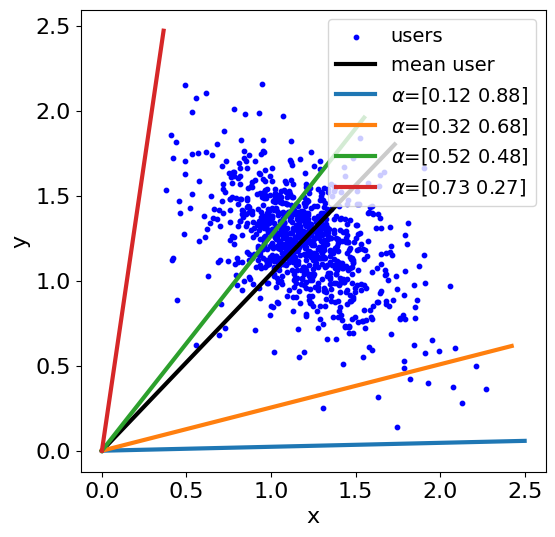

In [135]:

width = 6
height = 6

# Read data from files
p_vals_weighted2 = np.loadtxt('./Data/p_vals_weighted2.txt')
user_embeddings_weighted2 = np.loadtxt('./Data/user_embeddings_weighted2.txt')
mean_embedding_weighted2 = np.loadtxt('./Data/mean_embedding_weighted2.txt')

# Create a plot
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_weighted2[:, 0]
y_coordinates = user_embeddings_weighted2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)  # reduced marker size to 10
plt.plot(t * mean_embedding_weighted2[0], t * mean_embedding_weighted2[1], label='mean user', color='k', linewidth=3)

# Assuming cost_weights_all_2d is saved and needs to be loaded as well
cost_weights_all_2d = np.loadtxt('./Data/cost_weights_all_2d.txt')
for i in range(len(p_vals_weighted2)):
    p = p_vals_weighted2[i]
    cost_weights = cost_weights_all_2d[i]
    plt.plot(t * p[0], t * p[1], label=f'$\\alpha$={np.around(cost_weights, 2)}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-costs', bbox_inches='tight')




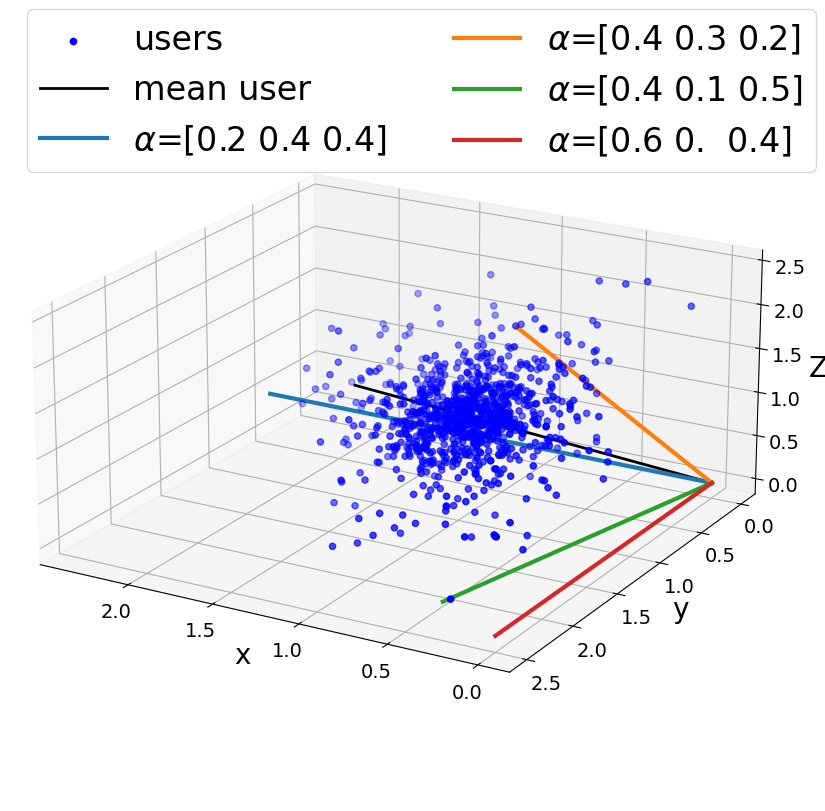

In [138]:


# Read data from files
cost_weights_all_3d = np.loadtxt('./Data/cost_weights_all_3d.txt')
p_vals_weighted3 = np.loadtxt('./Data/p_vals_weighted3.txt')
user_embeddings_weighted3 = np.loadtxt('./Data/user_embeddings_weighted3.txt')
mean_embedding_weighted3 = np.loadtxt('./Data/mean_embedding_weighted3.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

x_coordinates = user_embeddings_weighted3[:, 0]
y_coordinates = user_embeddings_weighted3[:, 1]
z_coordinates = user_embeddings_weighted3[:, 2]

t = np.linspace(0, 2.5, 100)

ax.scatter(x_coordinates, y_coordinates, z_coordinates, label='users', color='blue')
ax.plot(t * mean_embedding_weighted3[0], t * mean_embedding_weighted3[1], t * mean_embedding_weighted3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_weighted3)):
    p = p_vals_weighted3[i]
    cost_weights = cost_weights_all_3d[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'$\\alpha$={np.around(cost_weights, 1)}', linewidth=3)


ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-costs', bbox_inches='tight')


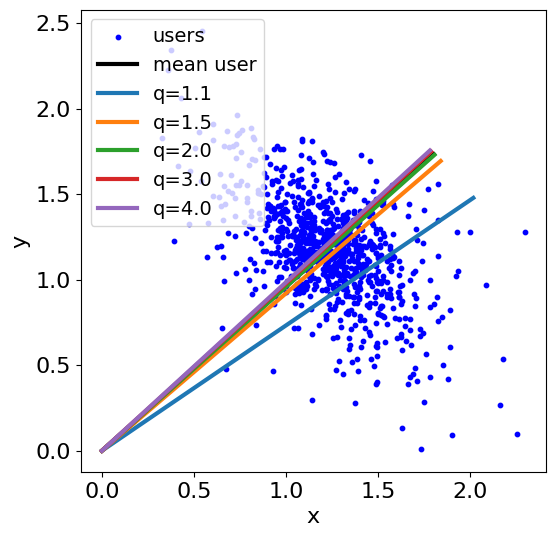

In [137]:
# Read data from files
p_vals_qvals2 = np.loadtxt('./Data/p_vals_qvals2.txt')
user_embeddings_qvals2 = np.loadtxt('./Data/user_embeddings_qvals2.txt')
mean_embedding_qvals2 = np.loadtxt('./Data/mean_embedding_qvals2.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 6
height = 6
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_qvals2[:, 0]
y_coordinates = user_embeddings_qvals2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)
plt.plot(t * mean_embedding_qvals2[0], t * mean_embedding_qvals2[1], label='mean user', color='k', linewidth=3)

for i in range(len(p_vals_qvals2)):
    p = p_vals_qvals2[i]
    q = q_vals[i]
    plt.plot(t * p[0], t * p[1], label=f'q={q}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-q', bbox_inches='tight')


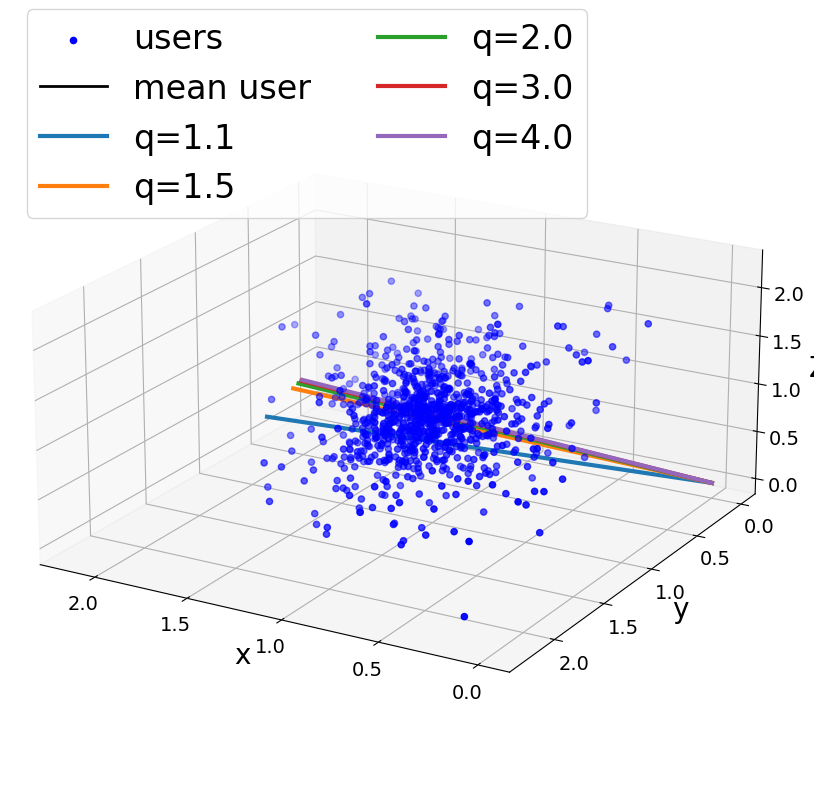

In [153]:

# Read data from files
p_vals_qvals3 = np.loadtxt('./Data/p_vals_qvals3.txt')
user_embeddings_qvals3 = np.loadtxt('./Data/user_embeddings_qvals3.txt')
mean_embedding_qvals3 = np.loadtxt('./Data/mean_embedding_qvals3.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

t = np.linspace(0, 2.5, 100)

ax.scatter(user_embeddings_qvals3[:, 0], user_embeddings_qvals3[:, 1], user_embeddings_qvals3[:, 2], label='users', color='blue')
ax.plot(t * mean_embedding_qvals3[0], t * mean_embedding_qvals3[1], t * mean_embedding_qvals3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_qvals3)):
    p = p_vals_qvals3[i]
    q = q_vals[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'q={q}', linewidth=3)

ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-q', bbox_inches='tight')


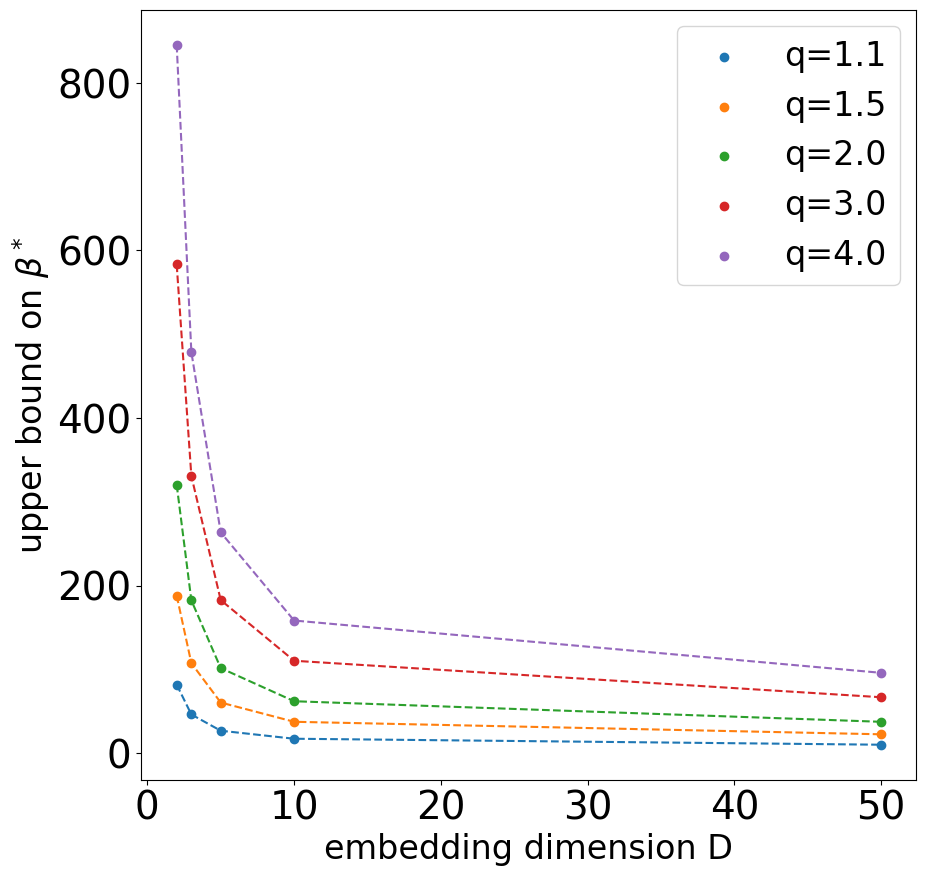

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')
dim_values = np.loadtxt('./Data/dim_values.txt')

width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(q_vals)):
    betas_val = betas[:, i]
    plt.scatter(dim_values, betas_val, label='q='+str(q_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('upper bound on $\\beta^*$', fontsize=24)
plt.savefig('./Plots/beta-q', bbox_inches='tight')


[1.5 1.6 1.8 2. ]
[[ 61.67425254  70.09728488  86.83793662 103.48361087]
 [ 36.97898253  41.8811782   51.6083963   61.26854642]
 [ 27.18141476  30.791158    37.95510508  45.07042329]
 [ 22.95954549  26.02139551  32.0818691   38.08943644]]
[ 5. 10. 20. 40.]


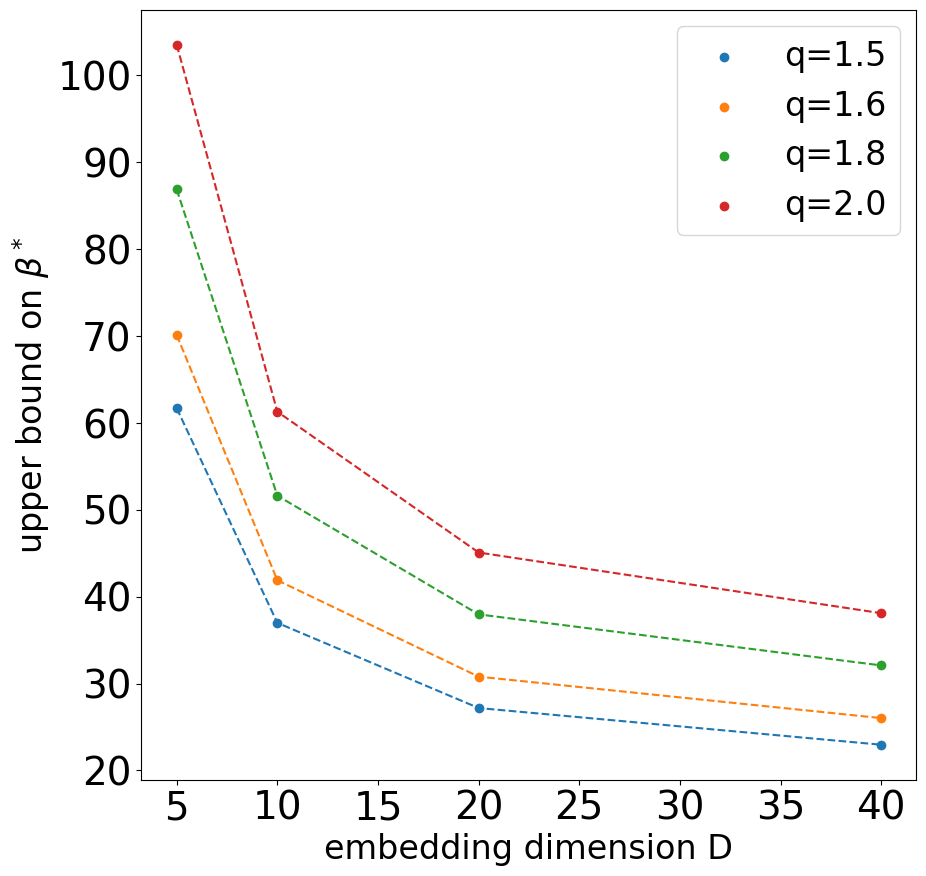

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas_small.txt')
q_vals = np.loadtxt('./Data/q_vals_small.txt')
dim_values = np.loadtxt('./Data/dim_values_small.txt')

print(q_vals)
print(betas)
print(dim_values)
width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(q_vals)):
    betas_val = betas[:, i]
    plt.scatter(dim_values, betas_val, label='q='+str(q_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('upper bound on $\\beta^*$', fontsize=24)
plt.savefig('./Plots/beta-q-small', bbox_inches='tight')


[4.56832311 3.58241439 2.92032432 2.802748  ]
[8.66178466 3.05626052 2.84371466 2.4926055 ]
[9.16296491 2.37112639 2.0307028  2.20308383]


Text(0, 0.5, 'estimate of $\\beta^*$')

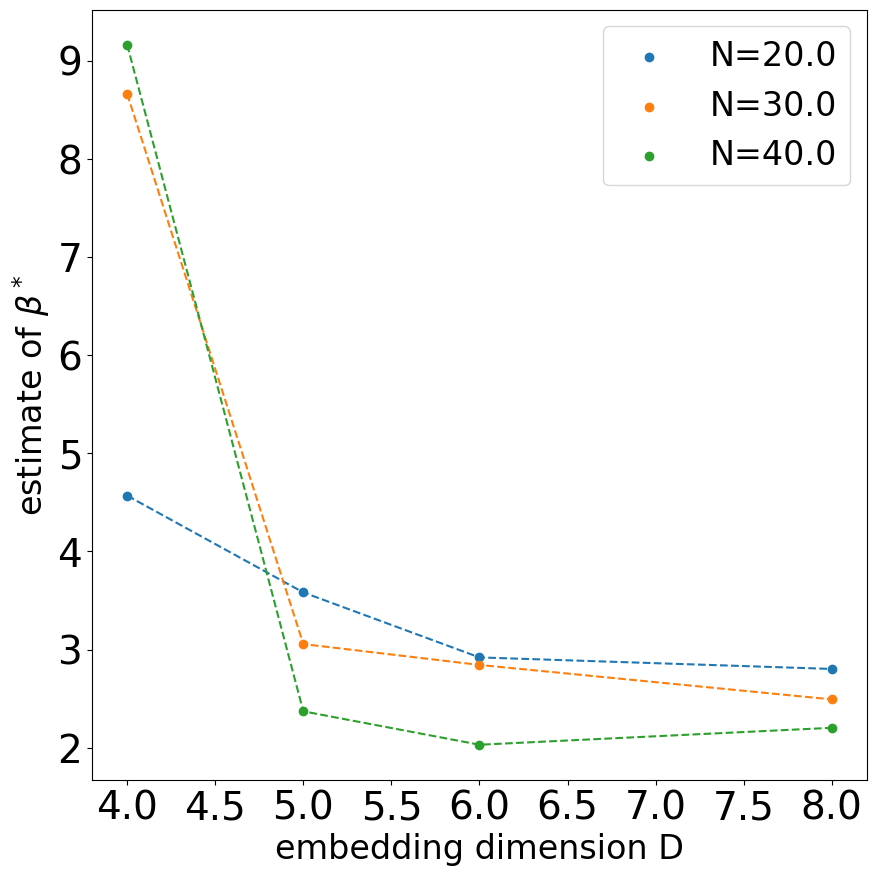

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas_actual.txt')
N_vals = np.loadtxt('./Data/N_vals_actual.txt')
dim_values = np.loadtxt('./Data/dim_values_actual.txt')

width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(N_vals)):
    betas_val = betas[i]
    print(betas_val)
    plt.scatter(dim_values, betas_val, label='N='+str(N_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('estimate of $\\beta^*$', fontsize=24)
# plt.savefig('./Plots/beta-q-actual', bbox_inches='tight')
